In [20]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from map4 import MAP4Calculator

## Read dataset

In [2]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (mhci['length'] == 9) &
            (~mhci['affinity_binding'].isin(dirty_values))]

In [4]:
data = []
AA = []

with open('IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-9.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:-1]:
        sline = line.strip().split('\t')
        AA.append(sline[0])
        data.append([float(v) for v in sline[1:]])

columns = list(range(1, 10))
pssm = pd.DataFrame(data=data, columns=columns, index=AA)

## Correlation between PSSM and exp. values

In [5]:
pssm_scores = []

for peptide in mhci.itertuples():
    score = 0
    
    for i, aa in enumerate(peptide.sequence):
        score += pssm.loc[aa][i + 1]
    
    pssm_scores.append(score)
    
pssm_scores = np.array(pssm_scores)

In [6]:
# Fit PSSM score to exp. values
reg = LinearRegression()
reg.fit(pssm_scores[:,None], mhci['energy'])
print('R2: %.3f' % reg.score(pssm_scores[:,None], mhci['energy']))
print('RMSD : %.3f kcal/mol' % rmsd(reg.predict(pssm_scores[:,None]), mhci['energy']))

R2: 0.644
RMSD : 1.189 kcal/mol


## Bayesian optimization

In [7]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [22]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [8]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

In [14]:
def predict_peptide_affinity_binding(sequences, pssm, reg, cutoff=-5.0):
    scores = []
    
    for sequence in sequences:
        score = 0
        
        for i, aa in enumerate(sequence):
            score += pssm.loc[aa][i + 1]
        
        scores.append(score)
    
    pred_scores = reg.predict(np.array(scores)[:,None])
    pred_scores[pred_scores > cutoff] = 0.
    
    return pred_scores


def generate_random_peptides(n_peptides, peptide_length, pssm, reg, energy_bounds, energy_cutoff):
    random_peptides = []
    random_peptide_scores = []

    while True:
        p = ''.join(np.random.choice(pssm.index, peptide_length))
        s = predict_peptide_affinity_binding([p], pssm, reg, cutoff=energy_cutoff)[0]

        if energy_bounds[0] <= s <= energy_bounds[1]:
            random_peptides.append(p)
            random_peptide_scores.append(s)

        if len(random_peptides) == n_peptides:
            break

    random_peptides = np.array(random_peptides)
    random_peptide_scores = np.array(random_peptide_scores)
    
    return random_peptides, random_peptide_scores

In [15]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_counted=False, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

In [16]:
class AcqScoring:
    def __init__(self, model, acq_fun, y_exp):
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        
    def evaluate(self, sequences):
        fps = map4_fingerprint(sequences)
        return self._acq_fun(self._model, self._y_exp, fps)

In [17]:
class PBIL(object):
    def __init__(self, scorer, peptide_length=9, population_size=96, n_best=48,
                 learning_rate=0.5, mut_prob=0.0, mut_shift=0.00, greater_is_better=True, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        
        # Scoring object
        self._scorer = scorer
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._greater_is_better = greater_is_better
        self._best_score = np.inf * (-1) ** (self._greater_is_better)

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        return self._scorer.evaluate([''.join(individual)])[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])
        
        if self._greater_is_better:
            sorted_peptide_indices = np.argsort(np.ravel(scores))[::-1]
        else:
            sorted_peptide_indices = np.argsort(np.ravel(scores))
        
        best_peptide_indices = sorted_peptide_indices[:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
            
            for amino_acid in amino_acids:
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])

In [18]:
def find_next_candidates(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96

    #Initialize the PBIL EDA
    pbil = PBIL(scorer, peptide_length=NLEN, population_size=NIND, n_best=NBEST,
                greater_is_better=greater_is_better)

    scaling_factor = (-1) ** (not greater_is_better)
    creator.create("Fitness", base.Fitness, weights=(scaling_factor,))
    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", pbil.evaluate)
    toolbox.register("generate", pbil.generate, creator.Individual)
    toolbox.register("update", pbil.update)

    # Statistics computation
    hof = tools.HallOfFame(NCAN)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)
    
    candidates = [''.join(s) for s in hof.items]
    candidates_acq = np.array([k.values[0] for k in hof.keys])

    return candidates, candidates_acq


def find_next_candidates_by_random(scorer, greater_is_better=True):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96
    AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    
    sequences = np.array([''.join(s) for s in np.random.choice(AA1, (NGEN * NIND, NLEN))])
    
    sequence_acqs = scorer.evaluate(sequences)
    
    if greater_is_better:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))[::-1]
    else:
        sorted_peptide_indices = np.argsort(np.ravel(sequence_acqs))
            
    candidates = sequences[sorted_peptide_indices[:NCAN]]
    candidate_acqs = sequence_acqs[sorted_peptide_indices[:NCAN]]
                        
    return candidates, candidate_acqs

### Candidate peptides sampling with PBIL

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.032
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 032
N pep under -6 kcal/mol: 089
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min       	max        
0  	250   	-0.00557817	0.0032242	-0.0207908	-0.00096396
1  	250   	-0.00785791	0.00495869	-0.0285234	-0.00166165
2  	250   	-0.0102963 	0.00552548	-0.0318148	-0.00202629
3  	250   	-0.0122815 	0.00630927	-0.0397162	-0.00252648
4  	250   	-0.0155142 	0.00657743	-0.0365998	-0.00397075
5  	250   	-0.0164535 	0.0063219 	-0.0364646	-0.00365268
6  	250   	-0.0185292 	0.00660351	-0.050673 	-0.0068067 
7  	250   	-0.0196709 	0.00687988	-0.0432134	-0.00629969
8  	250   	-0.0198859 	0.00642546	-0.0410384	-0.00687296
9  	250   	-0.021503  	0.00637597	-0.0425511	-0.00889663

N pep:  246
Best peptide: -12.492
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 011
N pep under -10 kcal/mol: 023
N pep under -9 kcal/mol: 057
N pep under -8 kcal/mol: 076
N pep under -7 kcal/mol: 122
N pep under -6 kcal/mol: 183
N pep under -5 kcal/mol: 246
Non binding pep        : 000


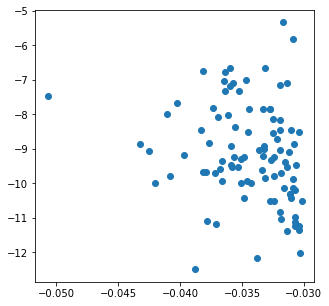




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-1.77469e-08	1.82192e-07	-2.84589e-06	-4.70097e-17
1  	250   	-3.09001e-05	0.000476941	-0.00755653 	-6.83944e-16
2  	250   	-4.93292e-06	3.40193e-05	-0.000419727	-1.43581e-13
3  	250   	-2.00739e-05	0.00024385 	-0.00385475 	-8.40369e-14
4  	250   	-8.20158e-06	3.35899e-05	-0.000330576	-1.4463e-10 
5  	250   	-8.95005e-05	0.000640347	-0.00732002 	-7.18043e-11
6  	250   	-0.000120059	0.000948432	-0.0122376  	-5.69745e-10
7  	250   	-0.000189984	0.00251388 	-0.0398223  	-9.75605e-10
8  	250   	-6.53588e-05	0.000314092	-0.00345102 	-1.67975e-09
9  	250   	-8.25183e-05	0.000675566	-0.0103132  	-5.14908e-10

N pep:  342
Best peptide: -12.710
N pep under -12 kcal/mol: 005
N pep under -11 kcal/mol: 033
N pep under -10 kcal/mol: 088
N pep under -9 kcal/mol: 148
N pep under -8 kcal/mol: 172
N pep under -7 kcal/mol: 218
N pep under -6 kcal/mol: 279
N pep under -5 kcal/mol: 342
Non binding pep        : 000


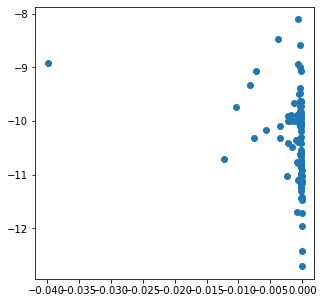




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std       	min         	max         
0  	250   	-2.31371e-09	2.4201e-08	-3.70452e-07	-1.48187e-20
1  	250   	-9.7284e-08 	9.80297e-07	-1.3014e-05 	-4.05181e-17
2  	250   	-5.134e-07  	3.74112e-06	-4.23863e-05	-1.5427e-17 
3  	250   	-2.39215e-05	0.000322705	-0.00508959 	-2.61754e-15
4  	250   	-7.1886e-06 	4.65105e-05	-0.000551624	-6.59604e-14
5  	250   	-0.000143304	0.001468   	-0.0172817  	-2.10309e-14
6  	250   	-0.000452719	0.00332552 	-0.0420526  	-1.15592e-12
7  	250   	-0.000201686	0.00249773 	-0.0392143  	-6.75656e-11
8  	250   	-4.27296e-05	0.000402745	-0.00621546 	-1.64417e-12
9  	250   	-0.000120729	0.000950578	-0.0104364  	-2.56242e-11

N pep:  438
Best peptide: -12.710
N pep under -12 kcal/mol: 007
N pep under -11 kcal/mol: 065
N pep under -10 kcal/mol: 163
N pep under -9 kcal/mol: 242
N pep under -8 kcal/mol: 268
N pep under -7 kcal/mol: 314
N pep under -6 kcal/mol: 375
N pep under -5 kcal/mol: 438
Non binding pep        : 000


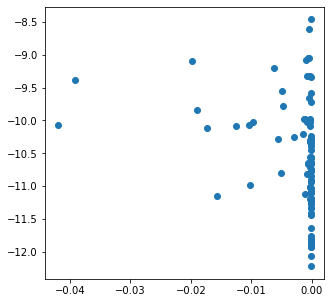




Run: 2
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.185
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 024
N pep under -6 kcal/mol: 079
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min        	max         
0  	250   	-0.00141773	0.00143827	-0.00880718	-5.32699e-05
1  	250   	-0.00248923	0.00238802	-0.0150255 	-0.000104262
2  	250   	-0.00314018	0.0024672 	-0.0133903 	-0.000143606
3  	250   	-0.00417814	0.00338957	-0.024786  	-0.000259414
4  	250   	-0.00539499	0.00333892	-0.0222694 	-0.00080574 
5  	250   	-0.00561146	0.00313572	-0.0177342 	-0.000738112
6  	250   	-0.00623299	0.00379644	-0.0231843 	-0.00108569 
7  	250   	-0.0072677 	0.00383421	-0.0235068 	-0.000813802
8  	250   	-0.00844054	0.00469569	-0.0307605 	-0.00149678 
9  	250   	-0.00902179	0.00482576	-0.0299679 	-0.00171532 

N pep:  246
Best peptide: -11.948
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 017
N pep under -9 kcal/mol: 052
N pep under -8 kcal/mol: 078
N pep under -7 kcal/mol: 117
N pep under -6 kcal/mol: 175
N pep under -5 kcal/mol: 246
Non binding pep        : 000


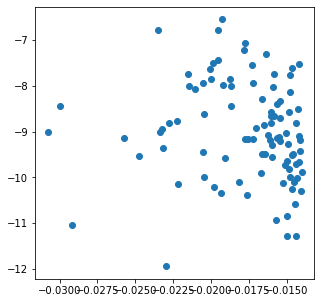




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std       	min        	max         
0  	250   	-7.76254e-08	9.5412e-07	-1.5013e-05	-5.09373e-20
1  	250   	-1.11295e-06	6.90232e-06	-7.5812e-05	-1.87975e-16
2  	250   	-7.99261e-06	7.41572e-05	-0.00113653	-8.09134e-14
3  	250   	-8.52484e-06	5.11705e-05	-0.000613177	-2.14809e-12
4  	250   	-7.64201e-06	3.28425e-05	-0.000316258	-6.90246e-14
5  	250   	-6.94681e-05	0.000789945	-0.0124132  	-1.34451e-12
6  	250   	-7.26291e-05	0.000512047	-0.0076353  	-4.73727e-11
7  	250   	-2.71729e-05	0.000101538	-0.000949117	-2.70824e-10
8  	250   	-9.91817e-05	0.000586761	-0.00868911 	-1.19027e-09
9  	250   	-0.000112474	0.0003987  	-0.00337145 	-1.769e-09  

N pep:  342
Best peptide: -12.125
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 017
N pep under -10 kcal/mol: 068
N pep under -9 kcal/mol: 133
N pep under -8 kcal/mol: 170
N pep under -7 kcal/mol: 213
N pep under -6 kcal/mol: 271
N pep under -5 kcal/mol: 342
Non binding pep        : 000


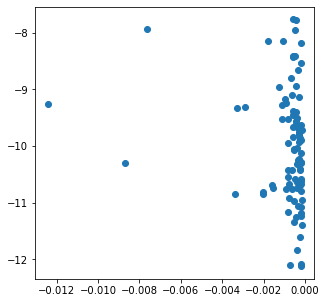




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max        
0  	250   	-6.12121e-08	6.45631e-07	-8.76453e-06	-8.6936e-18
1  	250   	-1.96219e-07	1.07287e-06	-9.28437e-06	-1.74088e-19
2  	250   	-4.25177e-05	0.000657238	-0.0104132  	-3.00153e-15
3  	250   	-1.00185e-05	9.12287e-05	-0.00134351 	-4.80915e-14
4  	250   	-3.80996e-05	0.000260108	-0.00339639 	-1.16524e-14
5  	250   	-7.32552e-06	4.52263e-05	-0.000553819	-9.23353e-15
6  	250   	-0.000130923	0.00110638 	-0.0135246  	-4e-14      
7  	250   	-0.000164307	0.00155514 	-0.0233227  	-2.25045e-12
8  	250   	-0.000135597	0.00101158 	-0.0148452  	-3.90269e-12
9  	250   	-0.000126498	0.00103335 	-0.0156902  	-7.84981e-13

N pep:  438
Best peptide: -12.582
N pep under -12 kcal/mol: 007
N pep under -11 kcal/mol: 036
N pep under -10 kcal/mol: 134
N pep under -9 kcal/mol: 222
N pep under -8 kcal/mol: 264
N pep under -7 kcal/mol: 309
N pep under -6 kcal/mol: 367
N pep under -5 kcal/mol: 438
Non binding pep        : 000


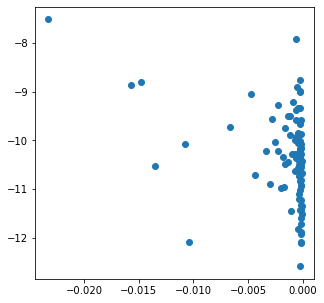




Run: 3
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.177
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 032
N pep under -6 kcal/mol: 099
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min        	max        
0  	250   	-0.00308799	2.95275e-09	-0.00308799	-0.00308798
1  	250   	-0.00308799	3.07722e-09	-0.00308799	-0.00308798
2  	250   	-0.00308799	2.96588e-09	-0.00308799	-0.00308798
3  	250   	-0.00308799	2.79614e-09	-0.00308799	-0.00308798
4  	250   	-0.00308799	2.78221e-09	-0.00308799	-0.00308798
5  	250   	-0.00308799	2.53856e-09	-0.00308799	-0.00308799
6  	250   	-0.00308799	2.53856e-09	-0.00308799	-0.00308799
7  	250   	-0.00308799	2.61841e-09	-0.00308799	-0.00308799
8  	250   	-0.00308799	2.58517e-09	-0.00308799	-0.00308799
9  	250   	-0.00308799	2.52133e-09	-0.00308799	-0.00308799

N pep:  246
Best peptide: -10.622
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 013
N pep under -8 kcal/mol: 038
N pep under -7 kcal/mol: 083
N pep under -6 kcal/mol: 174
N pep under -5 kcal/mol: 237
Non binding pep        : 009


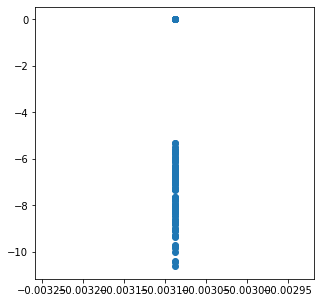




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00360373	0.00608075	-0.0567018	-3.18864e-05
1  	250   	-0.00552227	0.00583468	-0.0418951	-0.000205469
2  	250   	-0.00838496	0.00765797	-0.0452632	-0.000437874
3  	250   	-0.0126468 	0.0129925 	-0.108061 	-0.000567274
4  	250   	-0.0175847 	0.0135937 	-0.0671061	-0.000542201
5  	250   	-0.0174548 	0.0128689 	-0.0739059	-0.000587427
6  	250   	-0.0212565 	0.0170634 	-0.106258 	-0.00129777 
7  	250   	-0.0248553 	0.0186342 	-0.151532 	-0.00165998 
8  	250   	-0.0293315 	0.0194904 	-0.131141 	-0.00333268 
9  	250   	-0.0368297 	0.0272884 	-0.162245 	-0.00351396 

N pep:  342
Best peptide: -12.097
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 010
N pep under -10 kcal/mol: 037
N pep under -9 kcal/mol: 082
N pep under -8 kcal/mol: 131
N pep under -7 kcal/mol: 179
N pep under -6 kcal/mol: 270
N pep under -5 kcal/mol: 333
Non binding pep        : 009


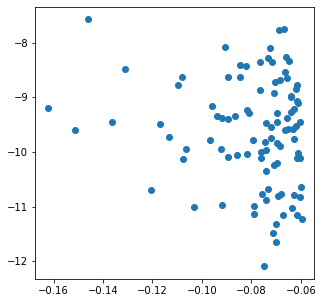




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min       	max         
0  	250   	-5.64181e-05	0.000168672	-0.0014937	-8.27168e-10
1  	250   	-0.000294106	0.000854763	-0.00740655	-1.80733e-08
2  	250   	-0.000950367	0.00570058 	-0.0857269 	-7.63583e-08
3  	250   	-0.000994247	0.00313705 	-0.0261195 	-2.28616e-07
4  	250   	-0.00121701 	0.00410418 	-0.0533809 	-1.01654e-07
5  	250   	-0.00172762 	0.00467419 	-0.053118  	-1.65209e-06
6  	250   	-0.00278999 	0.00934615 	-0.129642  	-1.13626e-07
7  	250   	-0.00300292 	0.00702528 	-0.0784279 	-2.99721e-06
8  	250   	-0.0033161  	0.00867458 	-0.094504  	-2.48706e-06
9  	250   	-0.00327486 	0.00675679 	-0.0586738 	-7.80578e-06

N pep:  438
Best peptide: -12.552
N pep under -12 kcal/mol: 002
N pep under -11 kcal/mol: 019
N pep under -10 kcal/mol: 086
N pep under -9 kcal/mol: 166
N pep under -8 kcal/mol: 223
N pep under -7 kcal/mol: 275
N pep under -6 kcal/mol: 366
N pep under -5 kcal/mol: 429
Non binding pep        : 009


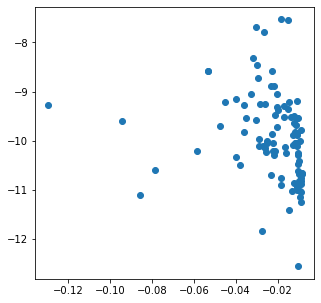




Run: 4
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.199
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 009
N pep under -7 kcal/mol: 035
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min        	max       
0  	250   	-0.00437952	3.85688e-09	-0.00437953	-0.0043795
1  	250   	-0.00437952	3.84271e-09	-0.00437953	-0.00437951
2  	250   	-0.00437952	3.65965e-09	-0.00437953	-0.00437951
3  	250   	-0.00437952	3.72794e-09	-0.00437953	-0.00437951
4  	250   	-0.00437952	3.8202e-09 	-0.00437953	-0.00437951
5  	250   	-0.00437952	3.63749e-09	-0.00437953	-0.00437951
6  	250   	-0.00437952	3.52909e-09	-0.00437953	-0.00437951
7  	250   	-0.00437952	3.30304e-09	-0.00437953	-0.00437952
8  	250   	-0.00437952	3.29471e-09	-0.00437953	-0.00437952
9  	250   	-0.00437952	3.00058e-09	-0.00437953	-0.00437952

N pep:  246
Best peptide: -10.755
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 013
N pep under -8 kcal/mol: 044
N pep under -7 kcal/mol: 093
N pep under -6 kcal/mol: 171
N pep under -5 kcal/mol: 239
Non binding pep        : 007


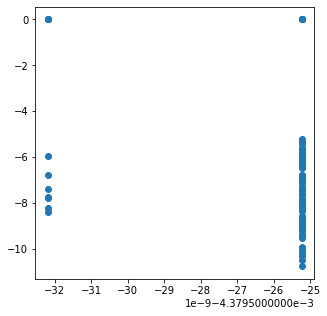




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max        
0  	250   	-0.00126738	0.00322832	-0.0262063	-1.1746e-07
1  	250   	-0.00260742	0.00572821	-0.0521227	-1.00659e-06
2  	250   	-0.0046799 	0.00727407	-0.0460107	-1.18431e-05
3  	250   	-0.00922787	0.0210467 	-0.231283 	-3.82617e-05
4  	250   	-0.0116605 	0.0176679 	-0.173631 	-3.25432e-05
5  	250   	-0.0143696 	0.0218302 	-0.185713 	-0.000113181
6  	250   	-0.0158323 	0.019331  	-0.159448 	-0.000544438
7  	250   	-0.0169832 	0.0239442 	-0.191099 	-0.000146168
8  	250   	-0.0230749 	0.0457538 	-0.583575 	-0.000273297
9  	250   	-0.0238453 	0.0332813 	-0.247156 	-0.000463629

N pep:  342
Best peptide: -12.218
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 018
N pep under -10 kcal/mol: 057
N pep under -9 kcal/mol: 097
N pep under -8 kcal/mol: 140
N pep under -7 kcal/mol: 189
N pep under -6 kcal/mol: 267
N pep under -5 kcal/mol: 335
Non binding pep        : 007


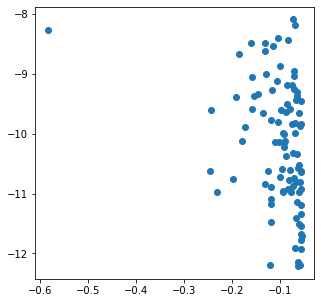




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min        	max         
0  	250   	-1.89474e-05	0.000128517	-0.00190803	-2.92687e-11
1  	250   	-0.000325447	0.00350042 	-0.0549217 	-2.85857e-12
2  	250   	-0.000271197	0.00176068 	-0.025797  	-1.77498e-09
3  	250   	-0.000401287	0.00140117 	-0.0145801 	-1.32512e-09
4  	250   	-0.00105467 	0.00394085 	-0.0434216 	-8.53008e-08
5  	250   	-0.00125961 	0.00451142 	-0.0443336 	-2.93506e-07
6  	250   	-0.00154397 	0.00906439 	-0.135168  	-1.54547e-07
7  	250   	-0.00197252 	0.00700702 	-0.0889915 	-2.34218e-07
8  	250   	-0.00295082 	0.00803648 	-0.076659  	-9.26999e-07
9  	250   	-0.003822   	0.0106227  	-0.0802246 	-8.63584e-07

N pep:  438
Best peptide: -12.218
N pep under -12 kcal/mol: 005
N pep under -11 kcal/mol: 039
N pep under -10 kcal/mol: 121
N pep under -9 kcal/mol: 187
N pep under -8 kcal/mol: 236
N pep under -7 kcal/mol: 285
N pep under -6 kcal/mol: 363
N pep under -5 kcal/mol: 431
Non binding pep        : 007


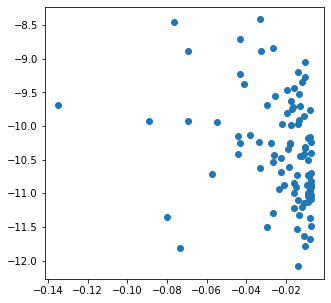




Run: 5
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.196
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 007
N pep under -7 kcal/mol: 035
N pep under -6 kcal/mol: 082
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max        
0  	250   	-0.00529396	0.0064147	-0.040327	-0.00011624
1  	250   	-0.00841722	0.00907579	-0.0724925	-0.000162515
2  	250   	-0.0117286 	0.00988468	-0.069069 	-0.000596886
3  	250   	-0.0149468 	0.0110687 	-0.0616752	-0.00107809 
4  	250   	-0.017439  	0.0113929 	-0.0682684	-0.000820301
5  	250   	-0.0216953 	0.0150346 	-0.125031 	-0.00242325 
6  	250   	-0.0257454 	0.0173696 	-0.104972 	-0.00356815 
7  	250   	-0.0281178 	0.0189852 	-0.157422 	-0.00256266 
8  	250   	-0.0295093 	0.0202523 	-0.130134 	-0.00317797 
9  	250   	-0.0325776 	0.0200915 	-0.13248  	-0.00465865 

N pep:  246
Best peptide: -12.200
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 013
N pep under -10 kcal/mol: 039
N pep under -9 kcal/mol: 069
N pep under -8 kcal/mol: 097
N pep under -7 kcal/mol: 131
N pep under -6 kcal/mol: 178
N pep under -5 kcal/mol: 246
Non binding pep        : 000


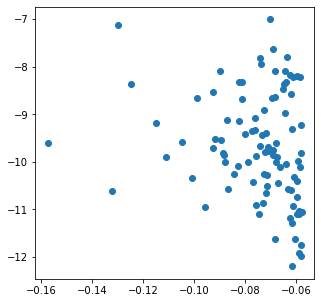




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-4.21707e-08	4.11457e-07	-6.27378e-06	-8.94602e-18
1  	250   	-1.22137e-06	1.31555e-05	-0.000205902	-1.2187e-16 
2  	250   	-2.61162e-06	1.54094e-05	-0.000191223	-1.44799e-13
3  	250   	-6.11895e-05	0.000572159	-0.00739559 	-1.44058e-14
4  	250   	-2.29776e-05	0.000114356	-0.00101439 	-1.04908e-12
5  	250   	-0.000232521	0.00292617 	-0.0461646  	-3.76659e-11
6  	250   	-8.4871e-05 	0.000559068	-0.00823213 	-7.05841e-12
7  	250   	-0.000146968	0.000682707	-0.00672458 	-1.90172e-10
8  	250   	-0.000624471	0.00632792 	-0.0919115  	-2.22816e-11
9  	250   	-0.000481307	0.00366333 	-0.0545278  	-1.65085e-09

N pep:  342
Best peptide: -12.503
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 036
N pep under -10 kcal/mol: 108
N pep under -9 kcal/mol: 158
N pep under -8 kcal/mol: 193
N pep under -7 kcal/mol: 227
N pep under -6 kcal/mol: 274
N pep under -5 kcal/mol: 342
Non binding pep        : 000


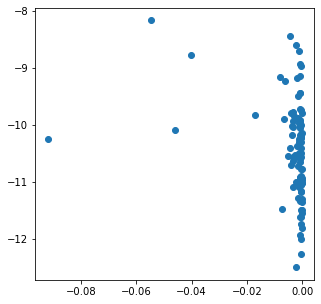




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min        	max         
0  	250   	-4.08195e-06	6.43357e-05	-0.00101928	-1.49907e-20
1  	250   	-9.46158e-08	7.67638e-07	-9.32268e-06	-7.43045e-18
2  	250   	-2.6814e-06 	3.31103e-05	-0.000514618	-3.63171e-21
3  	250   	-4.46673e-06	3.6537e-05 	-0.000547143	-8.79435e-16
4  	250   	-8.52937e-06	4.31889e-05	-0.000355722	-1.11346e-14
5  	250   	-1.81098e-05	0.000107154	-0.00110425 	-1.18131e-13
6  	250   	-0.000113252	0.000960984	-0.0124374  	-4.78757e-15
7  	250   	-0.000322031	0.00309206 	-0.0470204  	-2.53745e-12
8  	250   	-0.000146134	0.000950042	-0.012049   	-9.22759e-12
9  	250   	-0.000294956	0.00266037 	-0.0371565  	-7.51212e-12

N pep:  438
Best peptide: -12.503
N pep under -12 kcal/mol: 006
N pep under -11 kcal/mol: 062
N pep under -10 kcal/mol: 186
N pep under -9 kcal/mol: 253
N pep under -8 kcal/mol: 289
N pep under -7 kcal/mol: 323
N pep under -6 kcal/mol: 370
N pep under -5 kcal/mol: 438
Non binding pep        : 000


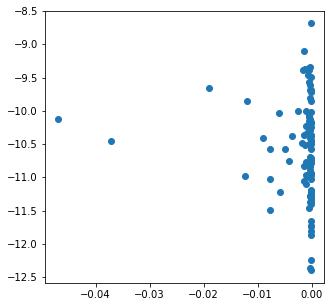




Run: 6
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.190
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 008
N pep under -7 kcal/mol: 042
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std      	min      	max         
0  	250   	-0.00641396	0.0100201	-0.103609	-8.10205e-05
1  	250   	-0.0121885 	0.0148538	-0.109483	-0.00012477 
2  	250   	-0.0142529 	0.0153706	-0.0816718	-0.000250884
3  	250   	-0.0188822 	0.0186957	-0.100104 	-0.00052904 
4  	250   	-0.0243656 	0.0219383	-0.123059 	-0.000940611
5  	250   	-0.0262007 	0.0224941	-0.118899 	-0.000998925
6  	250   	-0.0327293 	0.0279789	-0.236223 	-0.000902927
7  	250   	-0.0399228 	0.0330799	-0.221923 	-0.00208198 
8  	250   	-0.037199  	0.0327212	-0.171174 	-0.00183744 
9  	250   	-0.0386612 	0.0284261	-0.17048  	-0.00379731 

N pep:  246
Best peptide: -11.765
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 011
N pep under -9 kcal/mol: 026
N pep under -8 kcal/mol: 061
N pep under -7 kcal/mol: 117
N pep under -6 kcal/mol: 183
N pep under -5 kcal/mol: 245
Non binding pep        : 001


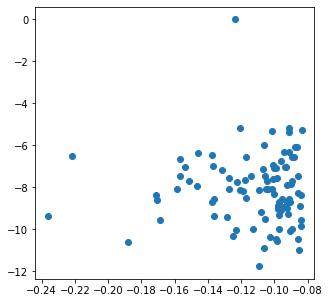




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-1.45809e-06	1.27625e-05	-0.000188436	-3.49324e-13
1  	250   	-3.62834e-06	1.38014e-05	-0.00014155 	-8.8733e-11 
2  	250   	-4.5398e-05 	0.000373507	-0.00455676 	-3.40743e-11
3  	250   	-5.62857e-05	0.000296079	-0.00343288 	-4.30762e-10
4  	250   	-0.000172387	0.00130185 	-0.0177079  	-7.57198e-10
5  	250   	-0.000264682	0.00182607 	-0.0237567  	-8.2412e-09 
6  	250   	-0.000182734	0.00107169 	-0.0151901  	-5.62096e-09
7  	250   	-0.000199255	0.000682538	-0.00874979 	-1.62251e-08
8  	250   	-0.000173481	0.000513202	-0.00484382 	-1.32584e-08
9  	250   	-0.000271378	0.00102349 	-0.011512   	-1.07127e-09

N pep:  342
Best peptide: -11.765
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 009
N pep under -10 kcal/mol: 051
N pep under -9 kcal/mol: 102
N pep under -8 kcal/mol: 154
N pep under -7 kcal/mol: 212
N pep under -6 kcal/mol: 279
N pep under -5 kcal/mol: 341
Non binding pep        : 001


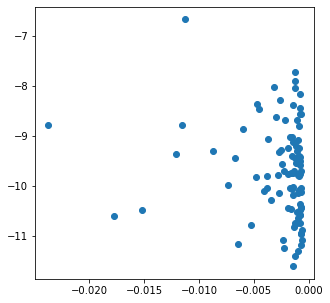




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min        	max         
0  	250   	-9.72226e-06	8.91743e-05	-0.00118026	-3.41821e-14
1  	250   	-3.96207e-05	0.000269894	-0.0036835 	-3.62033e-14
2  	250   	-0.000253308	0.00286869 	-0.0447548 	-6.69685e-14
3  	250   	-0.000346752	0.00226697 	-0.0282747 	-2.77131e-11
4  	250   	-0.00053031 	0.00401427 	-0.0611088 	-1.37931e-10
5  	250   	-0.00120161 	0.00970572 	-0.138666  	-2.24642e-10
6  	250   	-0.000791819	0.00371974 	-0.0522594 	-3.77289e-09
7  	250   	-0.00252482 	0.014646   	-0.206905  	-2.67164e-08
8  	250   	-0.00180752 	0.00940758 	-0.119706  	-8.87462e-08
9  	250   	-0.00171538 	0.00708104 	-0.0739349 	-2.61334e-08

N pep:  438
Best peptide: -12.542
N pep under -12 kcal/mol: 004
N pep under -11 kcal/mol: 036
N pep under -10 kcal/mol: 121
N pep under -9 kcal/mol: 197
N pep under -8 kcal/mol: 250
N pep under -7 kcal/mol: 308
N pep under -6 kcal/mol: 375
N pep under -5 kcal/mol: 437
Non binding pep        : 001


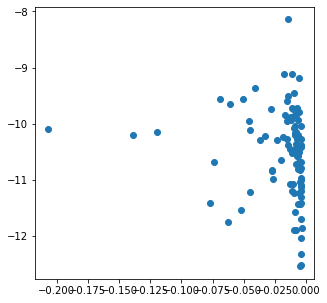




Run: 7
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.177
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 044
N pep under -6 kcal/mol: 087
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00579187	0.00597663	-0.0349977	-0.000280103
1  	250   	-0.0107268 	0.0106595 	-0.0935875	-0.000570975
2  	250   	-0.0158688 	0.0123407 	-0.0757286	-0.00176884 
3  	250   	-0.0213359 	0.0131073 	-0.0699708	-0.00249426 
4  	250   	-0.0242361 	0.0161036 	-0.106852 	-0.00417409 
5  	250   	-0.0296512 	0.0162778 	-0.0942361	-0.00684962 
6  	250   	-0.0338115 	0.0216917 	-0.199744 	-0.00564272 
7  	250   	-0.0381053 	0.0200277 	-0.111143 	-0.00589895 
8  	250   	-0.0420562 	0.0185501 	-0.115396 	-0.00988672 
9  	250   	-0.0451651 	0.0198544 	-0.105514 	-0.00934515 

N pep:  246
Best peptide: -12.873
N pep under -12 kcal/mol: 007
N pep under -11 kcal/mol: 020
N pep under -10 kcal/mol: 053
N pep under -9 kcal/mol: 075
N pep under -8 kcal/mol: 095
N pep under -7 kcal/mol: 137
N pep under -6 kcal/mol: 183
N pep under -5 kcal/mol: 246
Non binding pep        : 000


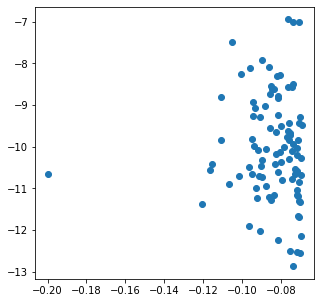




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min         	max         
0  	250   	-2.2694e-08	2.2068e-07	-3.13245e-06	-6.28147e-19
1  	250   	-1.21363e-07	7.44999e-07	-8.31954e-06	-2.3233e-16 
2  	250   	-1.48481e-05	0.000134811	-0.00186666 	-1.62622e-14
3  	250   	-2.24926e-06	1.96877e-05	-0.000276364	-4.66808e-14
4  	250   	-2.28794e-05	0.000168888	-0.00211804 	-1.10695e-12
5  	250   	-2.0841e-05 	0.000108577	-0.00135223 	-1.2665e-12 
6  	250   	-0.000218441	0.00223636 	-0.0337692  	-3.45538e-11
7  	250   	-0.000135286	0.00151871 	-0.0237178  	-8.0812e-11 
8  	250   	-8.955e-05  	0.000614615	-0.0080418  	-1.11765e-11
9  	250   	-0.000125672	0.000966587	-0.0132564  	-5.63837e-10

N pep:  342
Best peptide: -12.873
N pep under -12 kcal/mol: 014
N pep under -11 kcal/mol: 065
N pep under -10 kcal/mol: 130
N pep under -9 kcal/mol: 168
N pep under -8 kcal/mol: 191
N pep under -7 kcal/mol: 233
N pep under -6 kcal/mol: 279
N pep under -5 kcal/mol: 342
Non binding pep        : 000


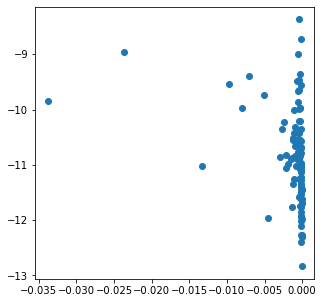




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-5.41222e-07	8.51813e-06	-0.000134955	-1.26635e-20
1  	250   	-1.34434e-07	1.58774e-06	-2.40282e-05	-1.79721e-18
2  	250   	-4.84395e-07	4.38062e-06	-6.57545e-05	-6.44418e-18
3  	250   	-6.67816e-07	6.8576e-06 	-0.000106281	-5.69193e-17
4  	250   	-5.99161e-05	0.000539991	-0.00764589 	-8.5571e-16 
5  	250   	-6.79737e-05	0.000939821	-0.0148775  	-2.90754e-14
6  	250   	-3.62439e-05	0.000306464	-0.00440647 	-1.32137e-13
7  	250   	-9.20194e-05	0.00106552 	-0.0166556  	-4.11346e-13
8  	250   	-3.53837e-05	0.000243084	-0.00317774 	-1.23633e-12
9  	250   	-9.87741e-05	0.000829181	-0.0110543  	-2.40917e-11

N pep:  438
Best peptide: -12.873
N pep under -12 kcal/mol: 016
N pep under -11 kcal/mol: 091
N pep under -10 kcal/mol: 192
N pep under -9 kcal/mol: 263
N pep under -8 kcal/mol: 286
N pep under -7 kcal/mol: 329
N pep under -6 kcal/mol: 375
N pep under -5 kcal/mol: 438
Non binding pep        : 000


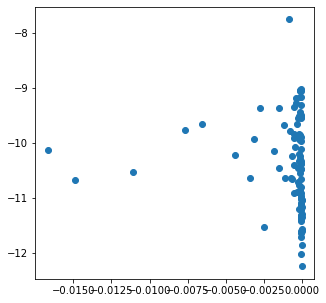




Run: 8
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.070
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 001
N pep under -7 kcal/mol: 033
N pep under -6 kcal/mol: 085
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std       	min       	max         
0  	250   	-0.00277397	0.00178513	-0.0106035	-0.000465182
1  	250   	-0.00425419	0.00266688	-0.0230889	-0.000635318
2  	250   	-0.00515138	0.00249992	-0.0172733	-0.00117911 
3  	250   	-0.00604558	0.00265708	-0.0162389	-0.00195066 
4  	250   	-0.00724683	0.00309478	-0.0175858	-0.00166737 
5  	250   	-0.00851703	0.00314146	-0.0205139	-0.00331556 
6  	250   	-0.00870258	0.00330304	-0.021198 	-0.00190057 
7  	250   	-0.00991581	0.00351973	-0.0259067	-0.00382552 
8  	250   	-0.01064   	0.00357106	-0.0251557	-0.00372307 
9  	250   	-0.0109434 	0.00342618	-0.0223608	-0.0039725  

N pep:  246
Best peptide: -12.233
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 012
N pep under -9 kcal/mol: 031
N pep under -8 kcal/mol: 056
N pep under -7 kcal/mol: 115
N pep under -6 kcal/mol: 179
N pep under -5 kcal/mol: 246
Non binding pep        : 000


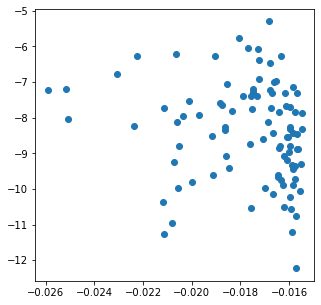




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-3.21666e-08	2.79484e-07	-3.57109e-06	-3.30103e-18
1  	250   	-3.24441e-08	1.91491e-07	-2.06508e-06	-2.49307e-15
2  	250   	-3.44515e-07	3.60103e-06	-5.569e-05  	-4.31481e-14
3  	250   	-1.86219e-06	1.57303e-05	-0.00018684 	-4.80003e-14
4  	250   	-1.88655e-06	1.05849e-05	-0.000101089	-1.00902e-13
5  	250   	-3.04762e-06	2.60284e-05	-0.000397494	-8.69316e-13
6  	250   	-1.74966e-05	0.000167141	-0.00212264 	-2.66096e-12
7  	250   	-3.76665e-05	0.000526829	-0.00834214 	-3.04109e-12
8  	250   	-7.71516e-06	5.74548e-05	-0.000847703	-2.31965e-11
9  	250   	-1.68706e-05	0.000112039	-0.00152938 	-3.54403e-12

N pep:  342
Best peptide: -12.233
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 010
N pep under -10 kcal/mol: 056
N pep under -9 kcal/mol: 111
N pep under -8 kcal/mol: 148
N pep under -7 kcal/mol: 211
N pep under -6 kcal/mol: 275
N pep under -5 kcal/mol: 342
Non binding pep        : 000


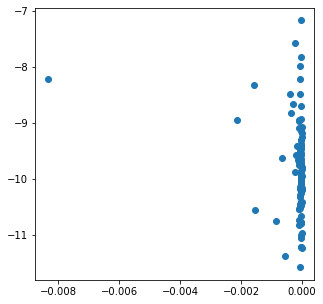




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-1.01659e-07	1.11516e-06	-1.71734e-05	-1.18883e-17
1  	250   	-5.1984e-07 	4.3435e-06 	-5.92962e-05	-4.61847e-17
2  	250   	-5.28985e-07	2.49783e-06	-2.66603e-05	-1.14224e-16
3  	250   	-1.89624e-06	1.69359e-05	-0.000260134	-8.03555e-14
4  	250   	-3.63971e-05	0.000350216	-0.00530987 	-4.64822e-14
5  	250   	-5.57756e-06	2.87331e-05	-0.000294873	-3.00505e-14
6  	250   	-2.4453e-05 	0.000219094	-0.00318527 	-6.25585e-13
7  	250   	-5.92256e-05	0.000520235	-0.00777295 	-6.61212e-12
8  	250   	-4.24354e-05	0.000298387	-0.00335536 	-1.9432e-13 
9  	250   	-8.88383e-05	0.000656262	-0.00994291 	-7.22935e-12

N pep:  438
Best peptide: -12.675
N pep under -12 kcal/mol: 002
N pep under -11 kcal/mol: 028
N pep under -10 kcal/mol: 123
N pep under -9 kcal/mol: 201
N pep under -8 kcal/mol: 244
N pep under -7 kcal/mol: 307
N pep under -6 kcal/mol: 371
N pep under -5 kcal/mol: 438
Non binding pep        : 000


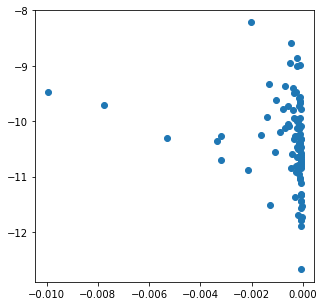




Run: 9
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.090
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 032
N pep under -6 kcal/mol: 081
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max         
0  	250   	-0.0023325	0.00274164	-0.0185454	-7.64868e-05
1  	250   	-0.00466131	0.00514488	-0.046667 	-0.00020819 
2  	250   	-0.00652667	0.00541244	-0.0360762	-0.000287323
3  	250   	-0.00920718	0.00641576	-0.0589971	-0.000884427
4  	250   	-0.0114207 	0.00764831	-0.040526 	-0.000656948
5  	250   	-0.0130371 	0.00797742	-0.04523  	-0.000820674
6  	250   	-0.0147923 	0.00811912	-0.0473746	-0.00149294 
7  	250   	-0.0163626 	0.0086376 	-0.0599479	-0.00294359 
8  	250   	-0.017343  	0.0089042 	-0.0528499	-0.00246263 
9  	250   	-0.0174564 	0.00834254	-0.0533231	-0.00375617 

N pep:  246
Best peptide: -11.410
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 024
N pep under -9 kcal/mol: 061
N pep under -8 kcal/mol: 087
N pep under -7 kcal/mol: 124
N pep under -6 kcal/mol: 177
N pep under -5 kcal/mol: 246
Non binding pep        : 000


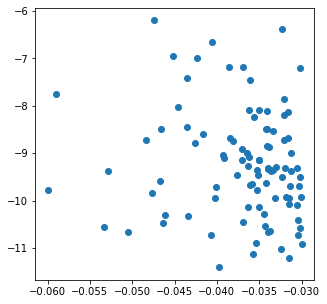




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min         	max         
0  	250   	-2.5751e-07	1.77229e-06	-2.51474e-05	-3.97187e-15
1  	250   	-7.15348e-05	0.00110164 	-0.0174542  	-4.83021e-14
2  	250   	-2.45078e-05	0.000182301	-0.00234732 	-1.23028e-15
3  	250   	-0.000111259	0.000804737	-0.011331   	-3.29761e-11
4  	250   	-0.000567252	0.00577993 	-0.083773   	-5.20119e-11
5  	250   	-0.000188568	0.00104526 	-0.0153858  	-5.98405e-11
6  	250   	-0.000220521	0.000829532	-0.00707687 	-1.24589e-09
7  	250   	-0.00048549 	0.00240673 	-0.031741   	-8.50915e-11
8  	250   	-0.000485749	0.00175504 	-0.0217467  	-3.72218e-09
9  	250   	-0.000611582	0.00185382 	-0.0205892  	-6.13414e-09

N pep:  342
Best peptide: -12.717
N pep under -12 kcal/mol: 007
N pep under -11 kcal/mol: 028
N pep under -10 kcal/mol: 080
N pep under -9 kcal/mol: 146
N pep under -8 kcal/mol: 180
N pep under -7 kcal/mol: 220
N pep under -6 kcal/mol: 273
N pep under -5 kcal/mol: 342
Non binding pep        : 000


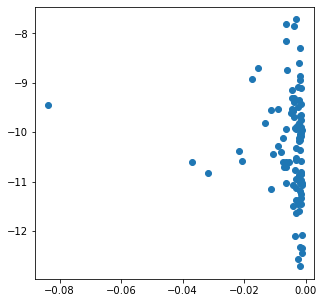




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min         	max         
0  	250   	-9.18471e-08	1.28472e-06	-2.02948e-05	-8.72175e-22
1  	250   	-2.03745e-07	1.8883e-06 	-2.24473e-05	-3.38504e-19
2  	250   	-3.59936e-06	5.28173e-05	-0.00083656 	-9.86467e-19
3  	250   	-5.11561e-06	5.71035e-05	-0.000874255	-2.45766e-15
4  	250   	-4.79952e-05	0.000391709	-0.00461903 	-1.61341e-13
5  	250   	-1.18012e-05	8.74555e-05	-0.00123738 	-2.18483e-14
6  	250   	-4.4409e-05 	0.000321218	-0.00479417 	-4.09099e-14
7  	250   	-3.48849e-05	0.000247955	-0.00291831 	-3.77509e-14
8  	250   	-6.42214e-05	0.000319136	-0.00401101 	-1.21331e-11
9  	250   	-0.000225638	0.00229902 	-0.033209   	-1.51407e-12

N pep:  438
Best peptide: -12.717
N pep under -12 kcal/mol: 010
N pep under -11 kcal/mol: 048
N pep under -10 kcal/mol: 158
N pep under -9 kcal/mol: 239
N pep under -8 kcal/mol: 276
N pep under -7 kcal/mol: 316
N pep under -6 kcal/mol: 369
N pep under -5 kcal/mol: 438
Non binding pep        : 000


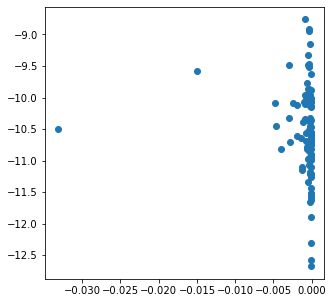




Run: 10
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.084
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 031
N pep under -6 kcal/mol: 088
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max         
0  	250   	-0.0047832	0.00755259	-0.0695007	-4.28898e-05
1  	250   	-0.00943325	0.0100246 	-0.0535094	-3.49876e-05
2  	250   	-0.0151408 	0.0139612 	-0.0639967	-0.000445107
3  	250   	-0.0211131 	0.0187569 	-0.0943314	-0.00036276 
4  	250   	-0.0289549 	0.0257725 	-0.157462 	-0.00211421 
5  	250   	-0.0289895 	0.0204481 	-0.15291  	-0.00281655 
6  	250   	-0.0332182 	0.022691  	-0.121469 	-0.00189339 
7  	250   	-0.0335356 	0.0242443 	-0.151517 	-0.00163001 
8  	250   	-0.0358103 	0.0239922 	-0.133601 	-0.0027547  
9  	250   	-0.0388557 	0.0264392 	-0.14054  	-0.00433121 

N pep:  246
Best peptide: -11.945
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 014
N pep under -9 kcal/mol: 035
N pep under -8 kcal/mol: 067
N pep under -7 kcal/mol: 115
N pep under -6 kcal/mol: 182
N pep under -5 kcal/mol: 246
Non binding pep        : 000


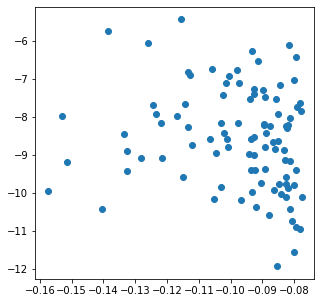




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std        	min        	max        
0  	250   	-1.24792e-07	1.32993e-06	-1.9817e-05	-2.5035e-17
1  	250   	-4.67052e-07	6.71489e-06	-0.000106366	-1.4185e-15
2  	250   	-1.70156e-05	0.000251196	-0.003977   	-2.79994e-15
3  	250   	-6.62259e-06	5.79654e-05	-0.00088245 	-4.69792e-13
4  	250   	-6.03726e-06	2.82e-05   	-0.000286533	-1.93805e-12
5  	250   	-6.0316e-06 	2.3146e-05 	-0.000234641	-3.5571e-12 
6  	250   	-9.69139e-06	5.12732e-05	-0.000515189	-1.91758e-10
7  	250   	-4.08686e-05	0.00055797 	-0.0088355  	-3.63403e-11
8  	250   	-1.01848e-05	4.6518e-05 	-0.000464238	-1.96039e-10
9  	250   	-1.57503e-05	6.79154e-05	-0.000637627	-6.75596e-12

N pep:  342
Best peptide: -12.084
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 008
N pep under -10 kcal/mol: 045
N pep under -9 kcal/mol: 100
N pep under -8 kcal/mol: 155
N pep under -7 kcal/mol: 211
N pep under -6 kcal/mol: 278
N pep under -5 kcal/mol: 342
Non binding pep        : 000


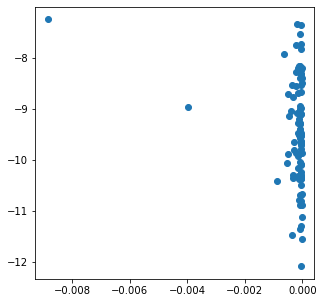




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg         	std       	min         	max         
0  	250   	-9.95815e-08	9.6957e-07	-1.39368e-05	-3.93805e-17
1  	250   	-5.01749e-07	5.10115e-06	-7.95585e-05	-9.9447e-16 
2  	250   	-1.48541e-05	0.000184963	-0.0028912  	-3.28524e-15
3  	250   	-2.91034e-05	0.000388332	-0.00613984 	-3.95791e-14
4  	250   	-1.92796e-05	0.000176987	-0.00229307 	-6.78243e-14
5  	250   	-3.95547e-05	0.000391167	-0.00526003 	-2.08903e-13
6  	250   	-1.37139e-05	6.58668e-05	-0.000692053	-6.46818e-12
7  	250   	-5.80806e-05	0.000367281	-0.00495373 	-5.7306e-12 
8  	250   	-0.000120802	0.000835994	-0.0107488  	-5.94016e-13
9  	250   	-9.05919e-05	0.00057613 	-0.00876655 	-7.28632e-11

N pep:  438
Best peptide: -12.180
N pep under -12 kcal/mol: 002
N pep under -11 kcal/mol: 017
N pep under -10 kcal/mol: 100
N pep under -9 kcal/mol: 185
N pep under -8 kcal/mol: 250
N pep under -7 kcal/mol: 307
N pep under -6 kcal/mol: 374
N pep under -5 kcal/mol: 438
Non binding pep        : 000


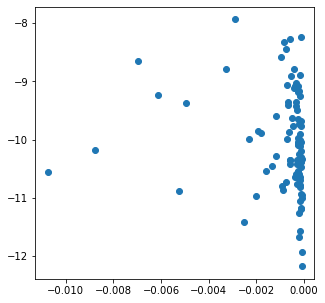

In [24]:
pbil_candidate_fps = []
pbil_candidate_y = []

n_peptides = 150
peptide_length = 9
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Generate random peptides
    random_peptides, random_peptide_scores = generate_random_peptides(n_peptides, peptide_length, pssm, reg,
                                                                      energy_bounds, energy_cutoff)
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(score_peptides(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    pbil_candidate_fps.append(X_fps_exp.detach().numpy())
    pbil_candidate_y.append(y_exp.detach().numpy())


pbil_candidate_fps = np.array(pbil_candidate_fps)
pbil_candidate_y = np.array(pbil_candidate_y)

### Random candidate peptides sampling

Run: 1
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.097
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 036
N pep under -6 kcal/mol: 089
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.071
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 014
N pep under -8 kcal/mol: 034
N pep under -7 kcal/mol: 092
N pep under -6 kcal/mol: 167
N pep under -5 kcal/mol: 239
Non binding pep        : 007


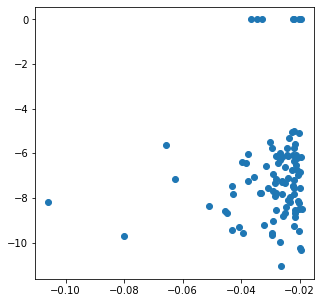




Generation: 2

N pep:  342
Best peptide: -11.755
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 008
N pep under -9 kcal/mol: 027
N pep under -8 kcal/mol: 081
N pep under -7 kcal/mol: 164
N pep under -6 kcal/mol: 258
N pep under -5 kcal/mol: 335
Non binding pep        : 007


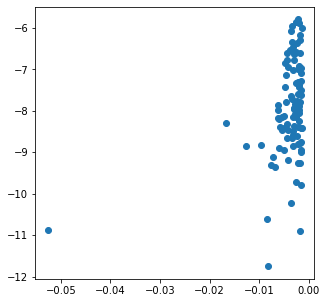




Generation: 3

N pep:  438
Best peptide: -11.755
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 005
N pep under -10 kcal/mol: 017
N pep under -9 kcal/mol: 054
N pep under -8 kcal/mol: 140
N pep under -7 kcal/mol: 242
N pep under -6 kcal/mol: 351
N pep under -5 kcal/mol: 431
Non binding pep        : 007


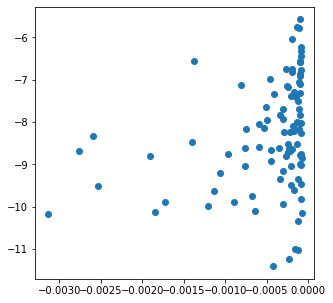




Run: 2
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -7.995
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
N pep under -7 kcal/mol: 024
N pep under -6 kcal/mol: 074
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.764
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 004
N pep under -9 kcal/mol: 014
N pep under -8 kcal/mol: 027
N pep under -7 kcal/mol: 075
N pep under -6 kcal/mol: 151
N pep under -5 kcal/mol: 239
Non binding pep        : 007


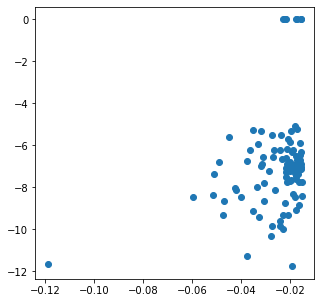




Generation: 2

N pep:  342
Best peptide: -11.764
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 006
N pep under -10 kcal/mol: 012
N pep under -9 kcal/mol: 034
N pep under -8 kcal/mol: 073
N pep under -7 kcal/mol: 145
N pep under -6 kcal/mol: 240
N pep under -5 kcal/mol: 334
Non binding pep        : 008


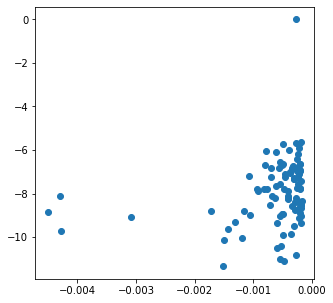




Generation: 3

N pep:  438
Best peptide: -11.764
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 007
N pep under -10 kcal/mol: 022
N pep under -9 kcal/mol: 071
N pep under -8 kcal/mol: 145
N pep under -7 kcal/mol: 233
N pep under -6 kcal/mol: 334
N pep under -5 kcal/mol: 430
Non binding pep        : 008


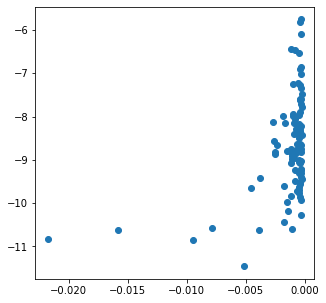




Run: 3
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.162
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
N pep under -7 kcal/mol: 038
N pep under -6 kcal/mol: 091
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.035
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 039
N pep under -7 kcal/mol: 102
N pep under -6 kcal/mol: 167
N pep under -5 kcal/mol: 240
Non binding pep        : 006


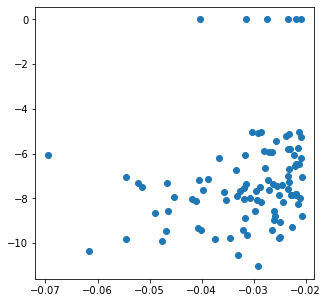




Generation: 2

N pep:  342
Best peptide: -11.155
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 010
N pep under -9 kcal/mol: 047
N pep under -8 kcal/mol: 089
N pep under -7 kcal/mol: 174
N pep under -6 kcal/mol: 257
N pep under -5 kcal/mol: 332
Non binding pep        : 010


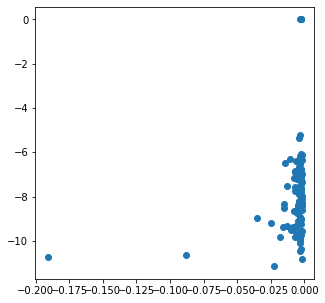




Generation: 3

N pep:  438
Best peptide: -11.762
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 006
N pep under -10 kcal/mol: 025
N pep under -9 kcal/mol: 080
N pep under -8 kcal/mol: 156
N pep under -7 kcal/mol: 265
N pep under -6 kcal/mol: 353
N pep under -5 kcal/mol: 428
Non binding pep        : 010


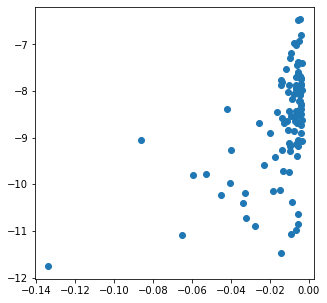




Run: 4
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.132
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 007
N pep under -7 kcal/mol: 037
N pep under -6 kcal/mol: 086
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.331
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 019
N pep under -8 kcal/mol: 041
N pep under -7 kcal/mol: 102
N pep under -6 kcal/mol: 172
N pep under -5 kcal/mol: 246
Non binding pep        : 000


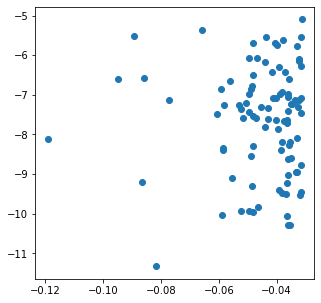




Generation: 2

N pep:  342
Best peptide: -11.331
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 038
N pep under -8 kcal/mol: 095
N pep under -7 kcal/mol: 184
N pep under -6 kcal/mol: 265
N pep under -5 kcal/mol: 341
Non binding pep        : 001


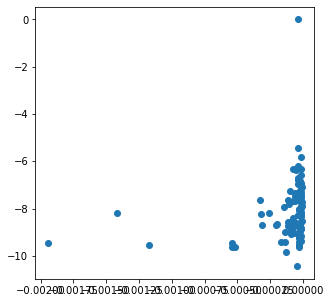




Generation: 3

N pep:  438
Best peptide: -11.331
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 014
N pep under -9 kcal/mol: 078
N pep under -8 kcal/mol: 166
N pep under -7 kcal/mol: 276
N pep under -6 kcal/mol: 361
N pep under -5 kcal/mol: 437
Non binding pep        : 001


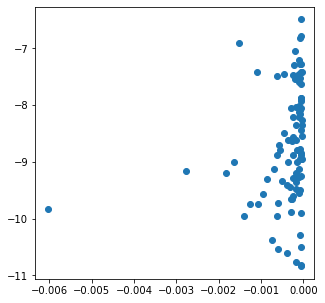




Run: 5
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.200
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
N pep under -7 kcal/mol: 035
N pep under -6 kcal/mol: 082
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.247
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 006
N pep under -9 kcal/mol: 016
N pep under -8 kcal/mol: 042
N pep under -7 kcal/mol: 101
N pep under -6 kcal/mol: 169
N pep under -5 kcal/mol: 245
Non binding pep        : 001


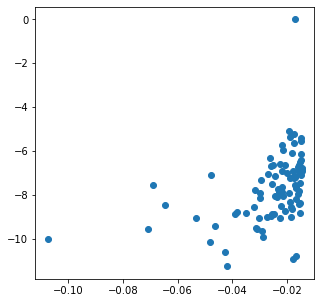




Generation: 2

N pep:  342
Best peptide: -11.616
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 017
N pep under -9 kcal/mol: 053
N pep under -8 kcal/mol: 101
N pep under -7 kcal/mol: 179
N pep under -6 kcal/mol: 264
N pep under -5 kcal/mol: 341
Non binding pep        : 001


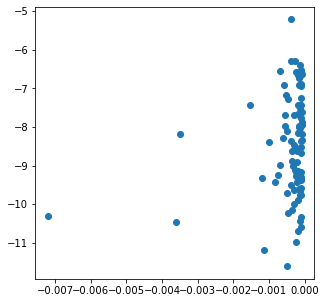




Generation: 3

N pep:  438
Best peptide: -11.616
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 023
N pep under -9 kcal/mol: 081
N pep under -8 kcal/mol: 170
N pep under -7 kcal/mol: 265
N pep under -6 kcal/mol: 357
N pep under -5 kcal/mol: 437
Non binding pep        : 001


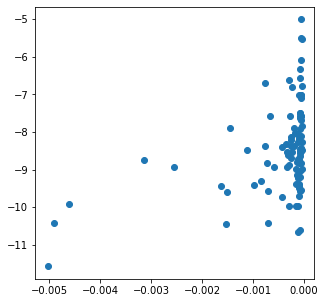




Run: 6
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.165
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 039
N pep under -6 kcal/mol: 089
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.678
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 009
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 042
N pep under -7 kcal/mol: 096
N pep under -6 kcal/mol: 165
N pep under -5 kcal/mol: 239
Non binding pep        : 007


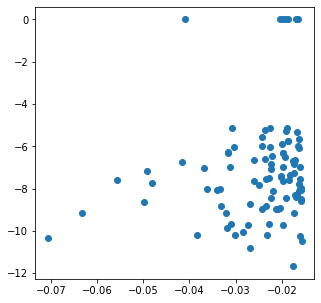




Generation: 2

N pep:  342
Best peptide: -11.678
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 019
N pep under -9 kcal/mol: 051
N pep under -8 kcal/mol: 102
N pep under -7 kcal/mol: 182
N pep under -6 kcal/mol: 258
N pep under -5 kcal/mol: 335
Non binding pep        : 007


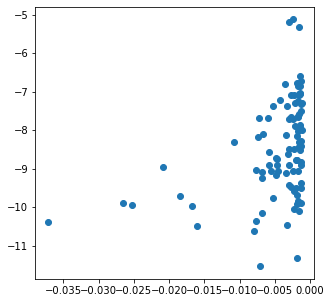




Generation: 3

N pep:  438
Best peptide: -12.013
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 007
N pep under -10 kcal/mol: 034
N pep under -9 kcal/mol: 082
N pep under -8 kcal/mol: 169
N pep under -7 kcal/mol: 271
N pep under -6 kcal/mol: 352
N pep under -5 kcal/mol: 431
Non binding pep        : 007


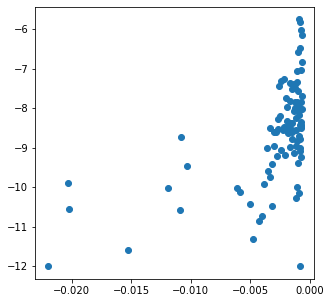




Run: 7
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.160
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 005
N pep under -7 kcal/mol: 032
N pep under -6 kcal/mol: 080
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -11.615
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 010
N pep under -9 kcal/mol: 017
N pep under -8 kcal/mol: 039
N pep under -7 kcal/mol: 090
N pep under -6 kcal/mol: 163
N pep under -5 kcal/mol: 243
Non binding pep        : 003


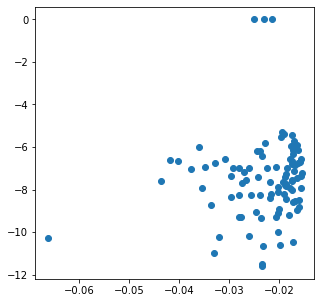




Generation: 2

N pep:  342
Best peptide: -11.615
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 021
N pep under -9 kcal/mol: 042
N pep under -8 kcal/mol: 097
N pep under -7 kcal/mol: 169
N pep under -6 kcal/mol: 256
N pep under -5 kcal/mol: 339
Non binding pep        : 003


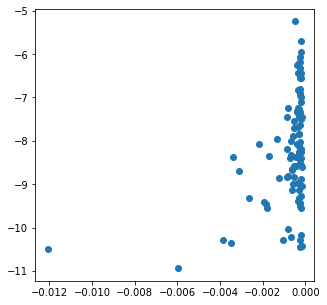




Generation: 3

N pep:  438
Best peptide: -11.964
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 029
N pep under -9 kcal/mol: 070
N pep under -8 kcal/mol: 167
N pep under -7 kcal/mol: 258
N pep under -6 kcal/mol: 350
N pep under -5 kcal/mol: 435
Non binding pep        : 003


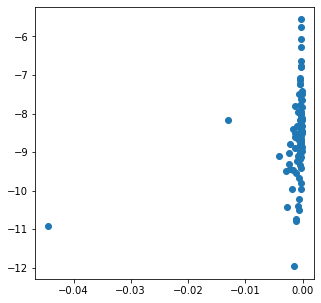




Run: 8
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.165
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 030
N pep under -6 kcal/mol: 081
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.427
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 015
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 090
N pep under -6 kcal/mol: 154
N pep under -5 kcal/mol: 236
Non binding pep        : 010


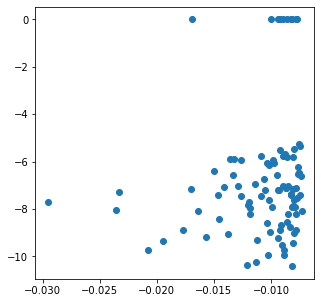




Generation: 2

N pep:  342
Best peptide: -11.136
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 009
N pep under -9 kcal/mol: 035
N pep under -8 kcal/mol: 079
N pep under -7 kcal/mol: 166
N pep under -6 kcal/mol: 245
N pep under -5 kcal/mol: 332
Non binding pep        : 010


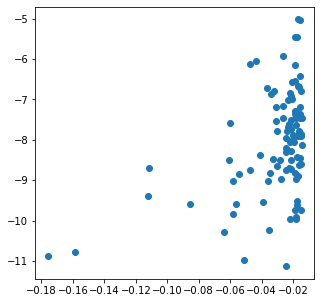




Generation: 3

N pep:  438
Best peptide: -11.735
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 021
N pep under -9 kcal/mol: 071
N pep under -8 kcal/mol: 146
N pep under -7 kcal/mol: 252
N pep under -6 kcal/mol: 340
N pep under -5 kcal/mol: 428
Non binding pep        : 010


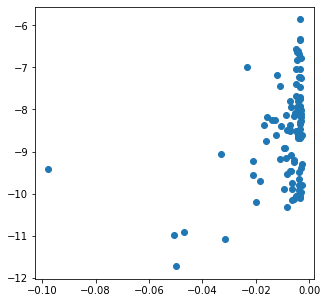




Run: 9
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.187
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 005
N pep under -7 kcal/mol: 037
N pep under -6 kcal/mol: 091
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -9.939
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 013
N pep under -8 kcal/mol: 035
N pep under -7 kcal/mol: 089
N pep under -6 kcal/mol: 169
N pep under -5 kcal/mol: 242
Non binding pep        : 004


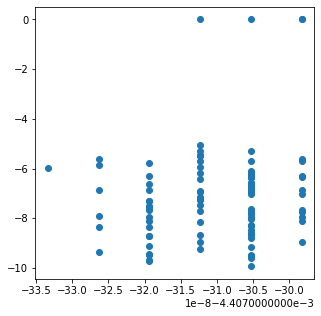




Generation: 2

N pep:  342
Best peptide: -11.600
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 014
N pep under -9 kcal/mol: 052
N pep under -8 kcal/mol: 103
N pep under -7 kcal/mol: 174
N pep under -6 kcal/mol: 263
N pep under -5 kcal/mol: 338
Non binding pep        : 004


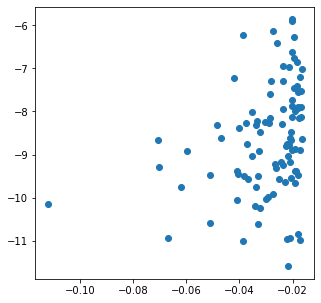




Generation: 3

N pep:  438
Best peptide: -11.600
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 023
N pep under -9 kcal/mol: 083
N pep under -8 kcal/mol: 175
N pep under -7 kcal/mol: 261
N pep under -6 kcal/mol: 358
N pep under -5 kcal/mol: 434
Non binding pep        : 004


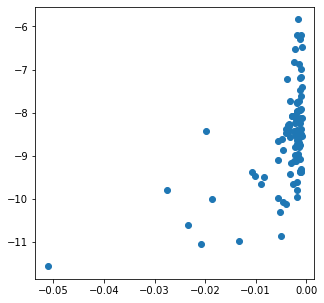




Run: 10
Exp dataset size: (150, 4096)



Init.
N pep:  150
Best peptide: -8.102
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 029
N pep under -6 kcal/mol: 086
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1

N pep:  246
Best peptide: -10.111
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 003
N pep under -9 kcal/mol: 014
N pep under -8 kcal/mol: 032
N pep under -7 kcal/mol: 094
N pep under -6 kcal/mol: 171
N pep under -5 kcal/mol: 242
Non binding pep        : 004


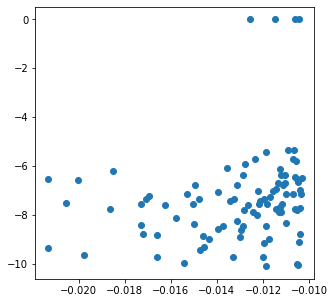




Generation: 2

N pep:  342
Best peptide: -10.686
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 008
N pep under -9 kcal/mol: 047
N pep under -8 kcal/mol: 093
N pep under -7 kcal/mol: 176
N pep under -6 kcal/mol: 261
N pep under -5 kcal/mol: 337
Non binding pep        : 005


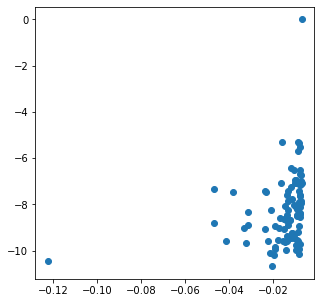




Generation: 3

N pep:  438
Best peptide: -12.324
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 022
N pep under -9 kcal/mol: 084
N pep under -8 kcal/mol: 161
N pep under -7 kcal/mol: 265
N pep under -6 kcal/mol: 357
N pep under -5 kcal/mol: 433
Non binding pep        : 005


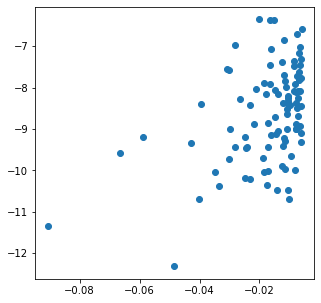

In [25]:
random_candidate_fps = []
random_candidate_y = []

n_peptides = 150
peptide_length = 9
energy_bounds = [-8.2, -5] # about between 1 and 250 uM
energy_cutoff = -5 # around 250 uM

for i in range(10):
    print('Run: %s' % (i + 1))
    
    # Generate random peptides
    random_peptides, random_peptide_scores = generate_random_peptides(n_peptides, peptide_length, pssm, reg,
                                                                      energy_bounds, energy_cutoff)
    
    # Compute the MAP4 fingerprint for all the peptides
    X_fps_exp = map4_fingerprint(random_peptides)
    y_exp = torch.from_numpy(random_peptide_scores).float()
    print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))
    
    print('\n\n')
    
    print('Init.')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

    print('\n\n')

    for j in range(3):
        print('Generation: %d' % (j + 1))
        # Train GP model
        model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

        # Find new candidates
        #acq = AcqScoring(model, probability_of_improvement, y_exp)
        acq = AcqScoring(model, expected_improvement, y_exp)
        candidate_sequences, candidates_acq = find_next_candidates_by_random(acq, greater_is_better=False)

        # Add candidates to the training set
        candidate_fps = map4_fingerprint(candidate_sequences)
        y_candidates = torch.from_numpy(np.array(score_peptides(candidate_sequences, pssm, reg)))

        X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
        y_exp = torch.cat([y_exp, y_candidates])

        print('')
        print('N pep: ', X_fps_exp.shape[0])
        print('Best peptide: %.3f' % y_exp.min())
        for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
            print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
        print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(candidates_acq, y_candidates.numpy())
        plt.show()

        print('\n\n')
    
    
    random_candidate_fps.append(X_fps_exp.detach().numpy())
    random_candidate_y.append(y_exp.detach().numpy())


random_candidate_fps = np.array(random_candidate_fps)
random_candidate_y = np.array(random_candidate_y)

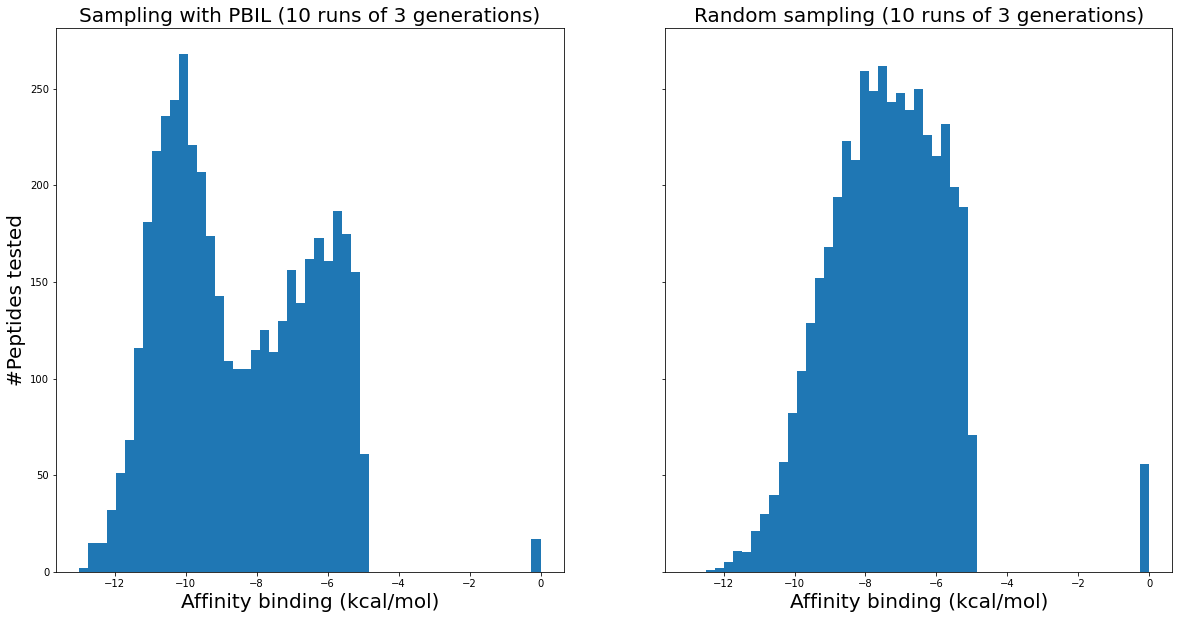

In [43]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
axarr[0].hist(pbil_candidate_y.flatten(), bins=np.linspace(-13, 0, 52))
axarr[1].hist(random_candidate_y.flatten(), bins=np.linspace(-13, 0, 52))

axarr[0].set_title('Sampling with PBIL (10 runs of 3 generations)', fontsize=20)
axarr[1].set_title('Random sampling (10 runs of 3 generations)', fontsize=20)

axarr[0].set_ylabel('#Peptides tested', fontsize=20)
axarr[0].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)
axarr[1].set_xlabel('Affinity binding (kcal/mol)', fontsize=20)

plt.savefig('figure_baye_opt_comparison_pbil_vs_random_sampling.png', dpi=300, bbox_inches='tight')
plt.show()